In [1]:
import numpy
from scipy import integrate, optimize
import emcee
import corner
%pylab inline
from scipy.stats import poisson
from galpy.util import plot as galpy_plot
import seaborn as sns
from matplotlib import ticker
galpy_plot.start_print(axes_labelsize=18.,text_fontsize=14.,
                       xtick_labelsize=16.,ytick_labelsize=16.)
_SAVE_FIGURES= True
_NSAMPLES= 30000

Populating the interactive namespace from numpy and matplotlib


# Novel constraints on the particle nature of dark matter from stellar streams

## Subhalo mass function measurements

### Subhalo mass function measurements from Banik et al. (2021)

Banik et al. (2021; B21) presented a measurement of the SHMF in the inner Milky Way derived from density perturbations to the GD-1 and Pal 5 stellar streams. These are presented as measurements of the abundance of satellites in three mass bins $[10^6,10^7]\,M_\odot$, $[10^7,10^8]\,M_\odot$, and $[10^8,10^9]\,M_\odot$; in the lowest-mass bin they only found an upper limit. Because they are relative to the abundance in a fiducial CDM mass function, we first need to implement the fiducial mass function:

In [2]:
def mass_function(m,c0=2.02*1e-13,m0=2.52*1e7,alpha=-1.9):
    return c0*(m/m0)**alpha

and the assumed Einasto spatial profile:

In [3]:
def spatial_profile(r,alpha=0.678,rm2=162.4):
    # Einasto, r in kpc
    return numpy.exp(-2./alpha*((r/rm2)**alpha-1.))

We then define the bins

In [4]:
low_mass_bins_e= [10.**6.,10.**7.,10.**8.,10.**9.]
low_mass_bins= 10.**((numpy.roll(numpy.log10(low_mass_bins_e),1)+numpy.log10(low_mass_bins_e))[1:]/2.)

The observed volume is the sphere extending out to 23 kpc. We can then compute the fiducial number (``rate=1``):

In [5]:
observed_volume= 23. # kpc
num_subs_cdm= numpy.array([integrate.quad(lambda m: mass_function(m),low_mass_bins_e[ii],low_mass_bins_e[ii+1])[0]\
              *integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]
          for ii in range(len(low_mass_bins))])

The actual measured number is relative to this

In [6]:
num_subs_obs= numpy.array([numpy.nan,0.2,0.2])
num_subs_obs_err_up= numpy.array([numpy.nan,0.7,0.5])
num_subs_obs_err_lo= numpy.array([numpy.nan,0.1,0.1])
num_subs_up_lim= numpy.array([3.6,numpy.nan,numpy.nan])

To use these measurements in fits of the SHMF in alternative dark matter models, we use the approximate representations of the full PDFs given in B21. These are given by the following code:

In [7]:
def skew_lnpdf(rate,peak=-0.7,sig_up=0.6,sig_lo=0.3,exponent=2.):
    out= numpy.empty_like(rate)
    out[rate<peak]= -0.5*numpy.fabs(rate[rate<peak]-peak)**exponent/sig_lo**2.
    out[rate>=peak]= -0.5*numpy.fabs(rate[rate>=peak]-peak)**exponent/sig_up**2.   
    return out
def skew_lnpdf_1e8to9(rate):
    return skew_lnpdf(rate,peak=-0.7,sig_up=0.6,sig_lo=0.3,exponent=2.)
def skew_lnpdf_1e7to8(rate):
    return skew_lnpdf(rate,peak=-0.5,sig_up=0.5,sig_lo=0.5,exponent=2.5)

We can then plot the PDFs of the rate in the two bins $[10^7,10^8]\,M_\odot$ and $[10^8,10^9]\,M_\odot$

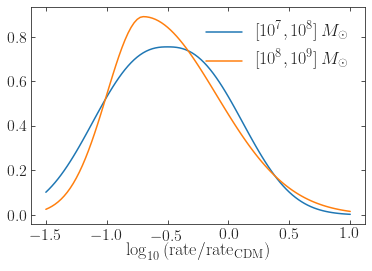

In [8]:
figsize(6,4)
rates= numpy.linspace(-1.5,1.,101)
pdf= numpy.exp(skew_lnpdf_1e7to8(rates))
pdf/= numpy.sum(pdf)*(rates[1]-rates[0])
plot(rates,pdf,label=r'$[10^7,10^8]\,M_\odot$')
pdf= numpy.exp(skew_lnpdf_1e8to9(rates))
pdf/= numpy.sum(pdf)*(rates[1]-rates[0])
plot(rates,pdf,label=r'$[10^8,10^9]\,M_\odot$')
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}\right)$')
legend(frameon=False,fontsize=18);

### SHMF measurements from classical dwarf satellites

We obtain additional information on the high-mass end of the SHMF by using the classical dwarfs, for which observations are complete out to 300 kpc. We obtain classical dwarfs and their stellar masses from Garrison-Kimmel et al. (2019):

In [9]:
sats= ['LMC','SMC','Sgr','Fornax','LeoI','Sculptor',
       'LeoII','Sextans','Carina','Ursa Minor','Draco','CVnI']
stellarmass= numpy.array([1.1*10.**9,3.7*10.**8.,3.4*10.**7.,2.4*10.**7.,4.9*10.**6.,3.9*10.**6.,
                         1.2*10.**6.,7*10.**5.,3.8*10.**5.,5.4*10.**5.,3.2*10.**5.,3*10.**5.])

We assign a halo mass using a stellar-mass--halo-mass relation from Bullock & Boylan-Kolchin (2017):

In [10]:
# Stellar-mass --> halo-mass from Bullock & Boylan-Kolchin (2017) [refer to Behroozi in prep.?]
def halo_mass(stellar_mass):
    return 10**(1./numpy.log10(300/2.2)*(numpy.log10(stellar_mass)-numpy.log10(3)-8)+11.)
halomass= halo_mass(stellarmass)

This gives the following:

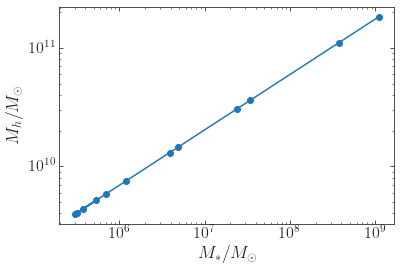

In [11]:
loglog(stellarmass,halo_mass(stellarmass),'o-')
xlabel(r'$M_*/M_\odot$')
ylabel(r'$M_h/M_\odot$');

The classical-dwarf SHMF measurements are over the volume out to 300 kpc, while the inner-Milky-Way SHMF measurements from stellar streams above only extend out to 23 kpc. We therefore extrapolate the inner Milky Way measurements to what they would have been out to 300 kpc using the Einasto spatial profile above:

In [12]:
scale_to_300kpc= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]\
                    /integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]

We then determine the classical-dwarf-range SHMF using the counts of satellites:

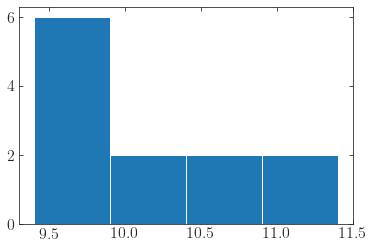

In [13]:
# Don't consider LMC/SMC
num_sats,e,_=hist(numpy.log10(halomass)[:],range=[9.4,11.4],bins=4);
mass_bins= 10.**((numpy.roll(e,1)+e)[1:]/2.)

In [14]:
mass_bins, num_sats

(array([4.46683592e+09, 1.41253754e+10, 4.46683592e+10, 1.41253754e+11]),
 array([6., 2., 2., 2.]))

We can then plot the observed SHMF:

In [15]:
def plot_observed_massfunction(add_mwdm=False,add_wdmmodels=False,add_single_wdm=None,
                               pred_amp_fac=1.6,include_lensing=False,correct_streams=1.):
    # Some keywords here to make adding lines later easier
    color_us= sns.color_palette("Paired")[1]
    galpy_plot.plot(low_mass_bins,num_subs_obs*num_subs_cdm*scale_to_300kpc*correct_streams,
                    marker='o',loglog=True,color=color_us,ls='none',
                    xlabel=r'$M_h/M_\odot$',ylabel=r'$dN/d\log_{10} M$',
                    xrange=[3e5*(True^(add_wdmmodels or (not add_single_wdm is None)))
                            +3e4*(add_wdmmodels or (not add_single_wdm is None)),1e12],
                    yrange=[8e-2*pred_amp_fac,(4e4+5.6e5*include_lensing)*pred_amp_fac])
    label=r'$\mathrm{Streams}\,(\mathrm{Banik\ et\ al.\,2021)}$'            
    line_us= errorbar(low_mass_bins,num_subs_obs*num_subs_cdm*scale_to_300kpc*correct_streams,
                      yerr=[num_subs_obs_err_lo*num_subs_cdm*scale_to_300kpc*correct_streams,
                      num_subs_obs_err_up*num_subs_cdm*scale_to_300kpc*correct_streams],
                      marker='o',ls='none',color=color_us,ms=8.,mew=2.,
                      label=label)
    errorbar(low_mass_bins,num_subs_up_lim*num_subs_cdm*scale_to_300kpc*correct_streams,
             yerr=num_subs_up_lim*num_subs_cdm*scale_to_300kpc*correct_streams/2.01,
             uplims=True,mew=2.,
             marker='_',ls='none',color=color_us,ms=10.)
    line_sats= errorbar(mass_bins,2*num_sats,yerr=2*numpy.sqrt(num_sats),
                        marker='*',ls='none',color=sns.color_palette("Paired")[5],ms=12.,
                        label=r'$\mathrm{Classical\ MW\ satellites}$')
    legend_handles= [line_us,line_sats]
    loc= 'lower left'
    if include_lensing:
        lensing_mass_bins= numpy.array([1e9,1e8,2.5e7])
        lensing_obs= numpy.array([1.,numpy.nan,numpy.nan])
        lensing_obs_err_up= numpy.array([60./8-1.,numpy.nan,numpy.nan])
        lensing_obs_err_lo= numpy.array([1.-1.5/8.,numpy.nan,numpy.nan])
        lensing_up_lim= numpy.array([numpy.nan,200./70.,60./2.5])
        color_lens= sns.color_palette("muted")[4]
        lensing_obs_plot= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function(m),
                                            lensing_mass_bins[ii]/numpy.sqrt(10.),
                                                               numpy.sqrt(10.)*lensing_mass_bins[ii])[0]\
                                 *mwvol for ii in range(len(lensing_mass_bins))])
        plot(lensing_mass_bins,lensing_obs_plot*lensing_obs,marker='o',color=color_lens,ls='none')
        label=r'$\mathrm{Strong\ lensing}\,(\mathrm{Hezaveh\ et\ al.\,2016)}$'            
        line_lens= errorbar(lensing_mass_bins,lensing_obs_plot*lensing_obs,
                            yerr=[lensing_obs_plot*lensing_obs_err_lo,
                                 lensing_obs_plot*lensing_obs_err_up],
                            marker='o',ls='none',color=color_lens,ms=8.,mew=2.,
                          label=label)
        errorbar(lensing_mass_bins,lensing_obs_plot*lensing_up_lim,
                 yerr=lensing_obs_plot*lensing_up_lim/1.251,
                 uplims=True,mew=2.,lw=2.,
                 marker='_',ls='none',color=color_lens,ms=10.)    
        legend_handles.append(line_lens)
        loc= 'upper right'
    l1= legend(handles=legend_handles,
               framealpha=1.,facecolor='w',edgecolor='none',
               fontsize=17.,loc=loc,frameon=False)
    gca().add_artist(l1)
    if add_mwdm:
        def mhalo_to_mwdm(mh):
            return 3.3*(mh/3e8)**-0.3
        minM,maxM= gca().get_xlim()
        ax1= gca()
        ax2= gca().twiny()
        ax2.set_xlim(mhalo_to_mwdm(minM),mhalo_to_mwdm(maxM))
        ax2.set_xlabel(r'$m_{\mathrm{WDM}}/\mathrm{keV}$')
        ax2.set_xscale('log')
        ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter(r'$%0.f$'))
        sca(ax1)
    return None

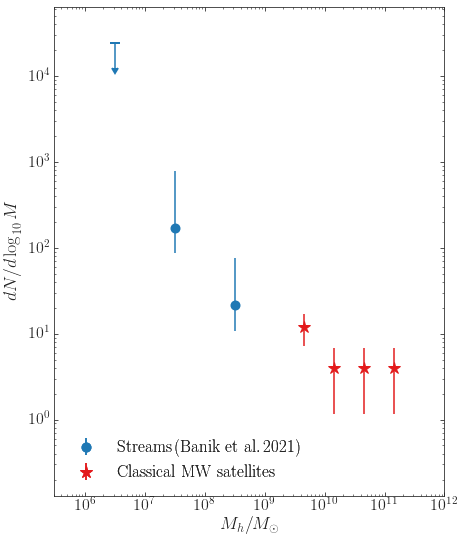

In [16]:
figsize(7,9)
plot_observed_massfunction()

We can compare these observations to the CDM prediction. For this, we implement a function to plot the CDM mass function. Note that because the observations are of integrals of the mass function over logarithmic bins, we also only plot such integrals. We also show a band showing the influence of baryonic disruption of subhalos in the inner Galaxy where they are constrained by streams:

In [17]:
def plot_cdm_massfunction(pred_amp_fac=1.6,noband=False):
    pred_ms= 10.**numpy.linspace(6.,11.5,11)
    mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
    prediction_cdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function(m),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                 *mwvol for ii in range(len(pred_ms))])
    line_pred_cdm= loglog(pred_ms,prediction_cdm,lw=2.,color='k',
                          label=r'$\mathrm{DM\ only}$',zorder=5)
    low_indx= pred_ms < 1e9
    if not noband:
        line_pred= fill_between(pred_ms[low_indx],
                                0.1*prediction_cdm[low_indx],0.5*prediction_cdm[low_indx],
                                color='0.75',zorder=0,
                               label=r'$\mathrm{incl.\ baryonic\, disruption}$')
        l2= legend(handles=[line_pred_cdm[0],line_pred],
               framealpha=1.,facecolor='w',edgecolor='none',
               fontsize=17.,loc='upper right',frameon=False)
        gca().add_artist(l2)
    return None

The resulting mass function is then:

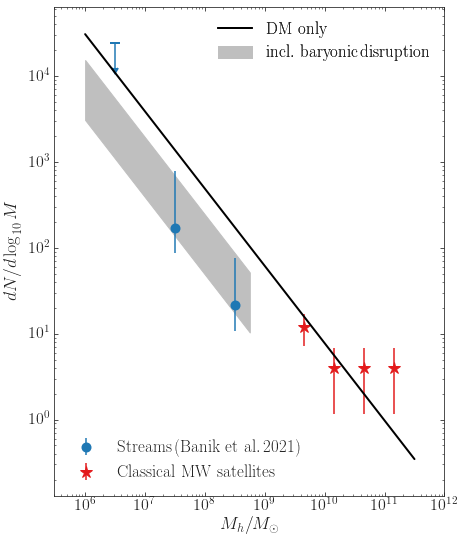

In [18]:
figsize(7,9)
plot_observed_massfunction()
plot_cdm_massfunction()

## Alternative dark matter models

### Warm dark matter

We model warm dark matter as a thermal relic. The mass function requires many parameters and some functions to define:

In [19]:
# Stuff to define the WDM mass function
nu= 1.12
OmDM= 0.2589
h= 0.6774
c0Mpc= 2.02*10**(-4) #Msun^-1 Mpc^-3
c0kpc= 2.02*10**(-13) #Msun^-1 kpc^-3
m0= 2.52*10**7 #Msun
default_beta= 0.99
default_gamma= 2.7
mf_slope= -1.9
al= 0.678 #alpha_shape
rm2= 199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
Om_m= 0.3089
rho_c= 1.27*10**11 #Msun/Mpc^3
rho_bar= Om_m*rho_c
# smoothly go to reduced CDM expectation below 10^9.5
red_fac= 10.**(0.5*(numpy.log10(0.1)+numpy.log10(0.5)))
# Functions to define the WDM mass function
def alpha(m_wdm):
    return (0.048/h)*(m_wdm)**(-1.11) #in Mpc , m_wdm in keV
def lambda_hm(m_wdm):
    return 2*numpy.pi*alpha(m_wdm)/(2**(nu/5.) - 1.)**(1/(2*nu))
def M_hm(m_wdm):
    return (4*numpy.pi/3)*rho_bar*(lambda_hm(m_wdm)/2.)**3

The mass function itself is then given by the following function. In this function, we also allow for the factor $f_\mathrm{survive}$ that accounts for tidal disruption by the baryonic component. It is called ``internal_red_fac`` here; this factor is only applied in the SHMF mass range probed by the streams in the inner Milky Way and for plotting, there is an option to turn it on smoothly:

In [20]:
def mass_function_wdm(m,c0=2.02*1e-13,m0=2.52*1e7,alpha=-1.9,
                      mwdm=2000.,gamma=default_gamma,beta=default_beta,Mhm=None,
                      smooth_reduction=False,internal_red_fac=red_fac):
    if smooth_reduction:
        reduction= (internal_red_fac+(1.-internal_red_fac)*2./numpy.pi*numpy.arctan(m/10**9.25))
    else:
        reduction= numpy.ones_like(m)
        reduction[m<10**9.2]= internal_red_fac
    if Mhm is None:
        return c0*(m/m0)**alpha*(1.+gamma*(M_hm(mwdm)/m))**-beta*reduction
    else:
        return c0*(m/m0)**alpha*(1.+gamma*(Mhm/m))**-beta*reduction

Note that we can get a CDM mass function simply by using a very high WDM mass. Let's also implement a plotting function to plot the WDM mass function. Note that because the observations are for integrals of the mass function over a logarithmic mass range, we also plot only such integrals:

In [21]:
def plot_wdm_massfunction(add_wdmmodels=False,
                          wdm_model=None,
                          pred_amp_fac=1.6,
                          add_single_wdm=None,
                          red_fac=red_fac):
    mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
    if add_wdmmodels:    
        pred_ms= 10.**numpy.linspace(6.,11.5,201)
        mwdms= [3.,6.,9.,12.,15.,20]
        text_heights= [3e0,3e1,1.25e2,3e2,6e2,1.3e3]
        for mwdm,text_height in zip(mwdms,text_heights):
            prediction_wdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_wdm(m,mwdm=mwdm,
                                                                                                internal_red_fac=red_fac),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                      *mwvol for ii in range(len(pred_ms))])
            prediction_wdm[(pred_ms>=10**8.7)*(pred_ms<10**9.7)]= numpy.nan
            line_pred_wdm= loglog(pred_ms,prediction_wdm,lw=2.,
                                  zorder=1,
                                  color=sns.color_palette()[1])
            galpy_plot.text(1e5,text_height,r'${:d}\,\mathrm{{keV}}$'.format(int(mwdm)),
                            size=17.,color=sns.color_palette()[1])
    if not add_single_wdm is None:
        pred_ms= 10.**numpy.linspace(6.,11.5,201)
        prediction_wdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_wdm(m,
                                                                                             mwdm=add_single_wdm,
                                                                                            internal_red_fac=red_fac),
                                        pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                  *mwvol for ii in range(len(pred_ms))])
        prediction_wdm[(pred_ms>=10**8.7)*(pred_ms<10**9.7)]= numpy.nan
        line_pred_wdm= loglog(pred_ms,prediction_wdm,lw=2.,
                              zorder=1,
                              color=sns.color_palette()[1])
        galpy_plot.text(7e4,8e1,r'$\mathrm{Warm\ DM:}$'+'\n'+r'${:d}\,\mathrm{{keV}}$'.format(int(add_single_wdm)),
                        size=17.,color=sns.color_palette()[1])
    if not wdm_model is None:
        pred_ms= 10.**numpy.linspace(6.,11.5,201)
        prediction_wdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_wdm(m,
                                                                                c0=numpy.exp(wdm_model[2])\
                                                                                    *2.02*1e-13,
                                                                                alpha=wdm_model[1],
                                                                                mwdm=1./wdm_model[0],
                                                                                            internal_red_fac=red_fac),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                      *mwvol for ii in range(len(pred_ms))])
        prediction_wdm[(pred_ms>=10**8.7)*(pred_ms<10**9.7)]= numpy.nan
        line_pred_wdm= loglog(pred_ms,prediction_wdm,lw=2.,
                              zorder=1,
                              color=sns.color_palette()[1])
    return None

We can then compare the data to WDM models with various WDM masses:

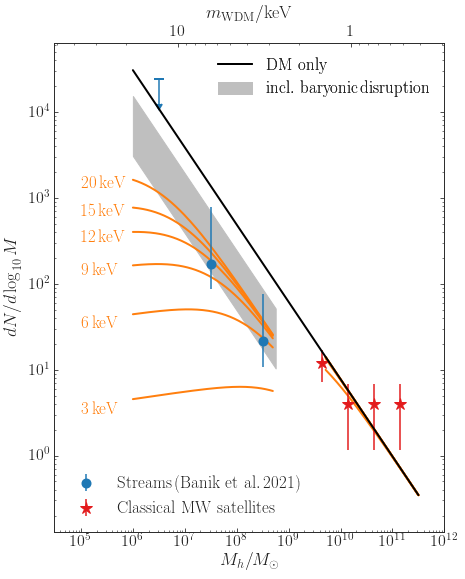

In [22]:
figsize(7,9)
plot_observed_massfunction(add_mwdm=True,add_wdmmodels=True)
plot_cdm_massfunction()
plot_wdm_massfunction(add_wdmmodels=True)
if _SAVE_FIGURES:
    pyplot.savefig('subhalo_massfunction_wwdm.pdf')

### Fuzzy dark matter

The following function implements the FDM SHMF, with the same accounting for baryonic disruption as for the WDM case above:

In [23]:
def mass_function_fdm(m,c0=2.02*1e-13,m0=2.52*1e7,alpha=-1.9,
                      mfdm=1., # m in 10^-22 eV
                      alpha1=0.72,M1m22=4.7,M2m22=2.0,
                      betam22=0.014,sigma=1.4,
                      smooth_reduction=False,internal_red_fac=red_fac):
    if smooth_reduction:
        reduction= (internal_red_fac+(1.-internal_red_fac)*2./numpy.pi*numpy.arctan(m/10**9.25))
    else:
        reduction= numpy.ones_like(m)
        reduction[m<10**9.2]= internal_red_fac
    beta= betam22*mfdm**1.5
    M1= M1m22*mfdm**-1.5
    M2= M2m22*mfdm**-1.6
    return reduction*(
        c0*(m/m0)**alpha*(1.+(m/(M2*1e8))**-alpha1)**(-10./alpha1)
        +beta/m/(113.094/1e8/c0)*numpy.exp(-numpy.log(m/(M1*1e8))**2./sigma))

We also implement a plotting function to show a single or a range of FDM models:

In [24]:
def plot_fdm_massfunction(add_fdmmodels=False,
                          pred_amp_fac=1.6,
                          add_single_fdm=None,
                          color=2,
                          red_fac=red_fac):
    mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
    if add_fdmmodels:    
        pred_ms= 10.**numpy.linspace(6.,11.5,201)
        mfdms= [15.,30.,50.,70.,100.,200.]
        text_heights= [1e0,1e1,0.6e2,1.5e2,4e2,1.3e3]
        galpy_plot.text(10**5.25,4e3,r'$m_{22}$',
                        size=17.,color=sns.color_palette()[color])
        for mfdm,text_height in zip(mfdms,text_heights):
            prediction_fdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_fdm(m,mfdm=mfdm,
                                                                                                internal_red_fac=red_fac),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                      *mwvol for ii in range(len(pred_ms))])
            prediction_fdm[(pred_ms>=10**8.7)*(pred_ms<10**9.7)]= numpy.nan
            line_pred_fdm= loglog(pred_ms,prediction_fdm,lw=2.,
                                  zorder=1,
                                  color=sns.color_palette()[color])
            galpy_plot.text(10**5.25,text_height,r'${:d}$'.format(int(mfdm)),
                            size=17.,color=sns.color_palette()[color])
    if not add_single_fdm is None:
        pred_ms= 10.**numpy.linspace(6.,11.5,201)
        prediction_fdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_fdm(m,
                                                                                             mfdm=add_single_fdm,
                                                                                            internal_red_fac=red_fac),
                                        pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                  *mwvol for ii in range(len(pred_ms))])
        prediction_fdm[(pred_ms>=10**8.7)*(pred_ms<10**9.7)]= numpy.nan
        line_pred_fdm= loglog(pred_ms,prediction_fdm,lw=2.,
                              zorder=1,
                              color=sns.color_palette()[color])
        galpy_plot.text(7e4,5e0,r'$\mathrm{Fuzzy\ DM:}$'+'\n'+r'$m_{{22}} = {:d}$'.format(int(add_single_fdm)),
                        size=17.,color=sns.color_palette()[color])
    return None

and we then plot a range of FDM models versus the data:

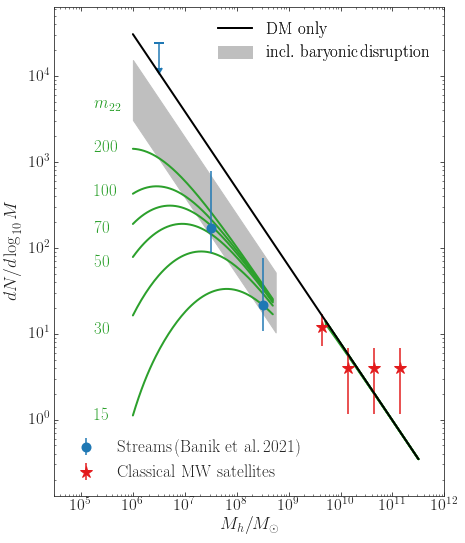

In [25]:
figsize(7,9)
plot_observed_massfunction(add_wdmmodels=True)
plot_cdm_massfunction()
plot_fdm_massfunction(add_fdmmodels=True)
if _SAVE_FIGURES:
    pyplot.savefig('subhalo_massfunction_wfdm.pdf')

## Constraints on warm dark matter

To constrain warm dark matter, we fit a model that varies the warm dark matter mass, the amplitude of the SHMF, its logarithmic slope, and the fraction of subhalos that survives tidal disruption in the inner Milky Way. The following function implements the likelihood. For the classical satellites, we use Poisson statistics, while for the lower-mass bins we use the distributions above. We implement three possible priors on the warm dark matter mass: (0) flat in 1/mass, (1) flat in log half-mode mass, and (2) flat in log mass. In practice, we only use the first two, because the third is equivalent to the second.

In [26]:
mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
def lnprob_wdm(p,wdm_prior=0,just_streams=False,beta=0.99,gamma=2.7,
               minalpha=-1.95,maxalpha=-1.85,minc0=1e-2,maxc0=1e2):
    if wdm_prior == 0: # flat in 1/mwdm
        mwdm= 1./p[0]
    elif wdm_prior == 1: # flat in log10(M_hm)
        if p[0] < 4.8 or p[0] > 10.: return -10000000000000.
        mwdm= optimize.brentq(lambda w: M_hm(w)-10.**p[0],0.01,100.)
    elif wdm_prior == 2: # flat in log10(mwdm)
        mwdm= 10.**p[0]
        if mwdm < 1.225 or mwdm > 45: return -10000000000000.
    alpha= p[1]
    c0= numpy.exp(p[2])
    red_fac= 10.**p[3]
    if red_fac < 0.001 or red_fac > 0.5: return -10000000000000.
    if mwdm < 0.: return -10000000000000.
    if alpha < minalpha or alpha > maxalpha: return -10000000000000.
    if c0 < minc0 or c0 > maxc0: return -10000000000000.
    if not just_streams:
        # Compute number of classical satellites predicted
        nclassical= numpy.array([integrate.quad(\
                    lambda m: mass_function_wdm(m,c0=c0*2.02*1e-13,
                                                alpha=alpha,mwdm=mwdm,
                                                beta=beta,gamma=gamma,
                                                internal_red_fac=red_fac),
                            mass_bins[ii]/numpy.sqrt(10.**0.5),numpy.sqrt(10.**0.5)*mass_bins[ii])[0]\
                                     *mwvol for ii in range(len(mass_bins))])
        # ln like is Poisson
        out= numpy.sum([poisson.logpmf(num_sats[ii],nclassical[ii]) for ii in range(len(mass_bins)-1)])
    else:
        out= 0.
    # Compute number of low-mass subhalos that we probe with streams and convert to rate
    nlowmass= numpy.array([integrate.quad(\
                    lambda m: mass_function_wdm(m,c0=c0*2.02*1e-13,
                                                alpha=alpha,mwdm=mwdm,
                                                beta=beta,gamma=gamma,
                                                internal_red_fac=red_fac),
                            low_mass_bins[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*low_mass_bins[ii])[0]\
                                 *mwvol for ii in range(len(low_mass_bins))])/num_subs_cdm/scale_to_300kpc
    out+= skew_lnpdf_1e7to8(numpy.log10(nlowmass[1]))+skew_lnpdf_1e8to9(numpy.log10(nlowmass[2]))
    return out
def lnlike_wdm(p,wdm_prior=0,just_streams=False,beta=0.99,gamma=2.7):
    return -lnprob_wdm(p,wdm_prior=wdm_prior,just_streams=just_streams,beta=beta,gamma=gamma)

We also implement some convenience functions to fit, MCMC sample, plot, and summarize the results:

In [27]:
def fit_wdm(wdm_prior=0,just_streams=False,beta=0.99,gamma=2.7):
    if wdm_prior == 0:
        init= [1./5.,-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 1:
        init= [numpy.log10(1e8),-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 2:
        init= [numpy.log10(5),-1.9,0.,numpy.log10(0.2)]
    return optimize.minimize(lambda x: lnlike_wdm(x,wdm_prior=wdm_prior,just_streams=just_streams,
                                                  beta=beta,gamma=gamma),
                             init,method='Powell')
def sample_wdm(wdm_prior=0,just_streams=False,beta=0.99,gamma=2.7,nwalkers=26,nburn=100,nsam=1000):
    # Setup initial ball
    if wdm_prior == 0:
        init= [1./5.,-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 1:
        init= [numpy.log10(1e8),-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 2:
        init= [numpy.log10(5),-1.9,0.,numpy.log10(0.2)]
    ndim= len(init)
    # initial Gaussian ball
    p0= numpy.array(init)\
        +numpy.random.rand(ndim*nwalkers).reshape((nwalkers,len(init)))
    # Iterate until have points with non zero likelihood (within the prior rage)
    while True:
        lp= numpy.array([lnprob_wdm(p,wdm_prior=wdm_prior,just_streams=just_streams,beta=beta,gamma=gamma) 
                         for p in p0])
        if numpy.all(lp > -10000000000000.0): break
        indx= lp <= -10000000000000.0
        p0[indx]= numpy.array(init)\
            +numpy.random.rand(ndim*numpy.sum(indx)).reshape((numpy.sum(indx),ndim))
    # Setup sampler
    sampler= emcee.EnsembleSampler(nwalkers,ndim,
                                   lambda x: lnprob_wdm(x,wdm_prior=wdm_prior,beta=beta,gamma=gamma,
                                                        just_streams=just_streams))
    pos, prob, state = sampler.run_mcmc(p0,nburn)
    sampler.reset()
    sampler.run_mcmc(pos,nsam)
    print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    return sampler.flatchain
def plot_corner_wdm(flatchain,wdm_prior=0,minalpha=-1.95,maxalpha=-1.85):
    plotthis= numpy.empty_like(flatchain)
    plotthis[:,0]= flatchain[:,0]
    plotthis[:,1]= flatchain[:,1]
    if wdm_prior == 0:
        mwdm_range= [0.,1.]
        wdm_label= r"$1/m_{\mathrm{WDM}}\,(\mathrm{keV}^{-1})$"
    elif wdm_prior == 1:
        mwdm_range= [4.8,10.]
        wdm_label= r"$\log_{10} M_\mathrm{hm} / M_\odot$"
    elif wdm_prior == 2:
        mwdm_range= [numpy.log10(1.225),numpy.log10(45.)]
        wdm_label= r"$\log_{10} m_{\mathrm{WDM}} / \mathrm{keV}$"
    plotthis[:,2]= numpy.exp(flatchain[:,2])
    plotthis[:,3]= 10.**flatchain[:,3]
    fig= corner.corner(plotthis,labels=[wdm_label,r"$\alpha$",r"$c_0$",r"$f_\mathrm{survive}$"],
                       range=[mwdm_range,[minalpha,maxalpha],[0.,5.],[0.01,0.5]],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
def plot_mwdm(flatchain,wdm_prior=0,cumul=False,color='k',overplot=False,ylabelpos=0.5):
    if wdm_prior == 0:
        plotthis= 1./flatchain[:,0]
    elif wdm_prior == 1:
        plotthis= numpy.array([optimize.brentq(lambda w: M_hm(w)-10.**Mhm,1.,100.) for Mhm in flatchain[:,0]])
    elif wdm_prior == 2:
        plotthis= 10.**flatchain[:,0]
    plotthis= numpy.log10(plotthis)
    if cumul:
        plot(sorted(plotthis),numpy.linspace(0.,1.,len(plotthis)),color=color,lw=2.)
        if not overplot: ylabel(r'$\mathrm{Cumulative\ PDF}$')
    else:
        hist(plotthis,range=[0.,1.55],bins=51,histtype='step',lw=2.,color=color,density=True)
        if not overplot: ylabel(r'$\mathrm{PDF}$')        
    if not overplot: xlabel(r"$\log_{10}( m_{\mathrm{WDM}}/\mathrm{keV})$")
    axvline(numpy.quantile(plotthis,0.05),color=color,ls='--')
    galpy_plot.text(0.1,ylabelpos,r'$m_{{\mathrm{{WDM}}}} > {:.1f}\,\mathrm{{keV}}$'
                    .format(numpy.quantile(10.**plotthis,0.05)),
                    fontsize=18.,color=color,backgroundcolor='w',zorder=100)
def print_mwdm_summary(flatchain,wdm_prior=0):
    if wdm_prior == 0:
        print("The 68% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.32)))
        print("The 95% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.05)))
        print("The 99.7% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.003)))
    elif wdm_prior == 1:
        print("The 68% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(optimize.brentq(lambda w: M_hm(w)-numpy.quantile(10.**flatchain[:,0],0.68),
                                 1.,100.)))
        print("The 95% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(optimize.brentq(lambda w: M_hm(w)-numpy.quantile(10.**flatchain[:,0],0.95),
                                 1.,100.)))
        print("The 99.7% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(optimize.brentq(lambda w: M_hm(w)-numpy.quantile(10.**flatchain[:,0],0.997),
                                 1.,100.)))
    elif wdm_prior == 2:
        print("The 68% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.32)))
        print("The 95% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.05)))
        print("The 99.7% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.003)))

### Constraints from streams alone

First, we look at the constraints from streams alone. Running with a prior that is flat in log-half-mass, we get:

In [28]:
opt= fit_wdm(wdm_prior=1,just_streams=True)
flatchain= sample_wdm(wdm_prior=1,just_streams=True,nsam=_NSAMPLES)
# Save for later use
flatchain_juststreams_Mhm= flatchain.copy()
print_mwdm_summary(flatchain,wdm_prior=1)

Mean acceptance fraction: 0.431
The 68% lower limit on the warm dark matter mass is 10.33 keV
The 95% lower limit on the warm dark matter mass is 3.64 keV
The 99.7% lower limit on the warm dark matter mass is 1.69 keV


or with a prior that is flat in one over mass:

In [29]:
opt= fit_wdm(wdm_prior=0,just_streams=True)
flatchain= sample_wdm(wdm_prior=0,just_streams=True,nsam=_NSAMPLES)
print_mwdm_summary(flatchain,wdm_prior=0)

Mean acceptance fraction: 0.418
The 68% lower limit on the warm dark matter mass is 5.36 keV
The 95% lower limit on the warm dark matter mass is 2.09 keV
The 99.7% lower limit on the warm dark matter mass is 1.29 keV


### Constraints including the classical satellite counts

Next, we add the constraints coming from the classical satellite counts. Starting again with the prior that is flat in log-half-mass:

In [30]:
opt= fit_wdm(wdm_prior=1)
flatchain= sample_wdm(wdm_prior=1,nsam=_NSAMPLES)
flatchain_Mhm= flatchain.copy()
print_mwdm_summary(flatchain,wdm_prior=1)

Mean acceptance fraction: 0.482
The 68% lower limit on the warm dark matter mass is 12.86 keV
The 95% lower limit on the warm dark matter mass is 6.21 keV
The 99.7% lower limit on the warm dark matter mass is 3.76 keV


We compare the PDF on the warm dark matter mass to that obtained from streams alone:

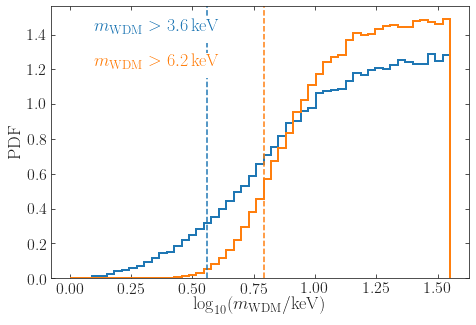

In [31]:
figsize(7.5,5)
plot_mwdm(flatchain_juststreams_Mhm,wdm_prior=1,color=u'#1f77b4',ylabelpos=1.4)
plot_mwdm(flatchain,wdm_prior=1,overplot=True,color=u'#ff7f0e',ylabelpos=1.2) # u'#2ca02c'
if _SAVE_FIGURES:
    pyplot.savefig('mwdm_pdf.pdf')

We also plot the corner plot of the MCMC samples:

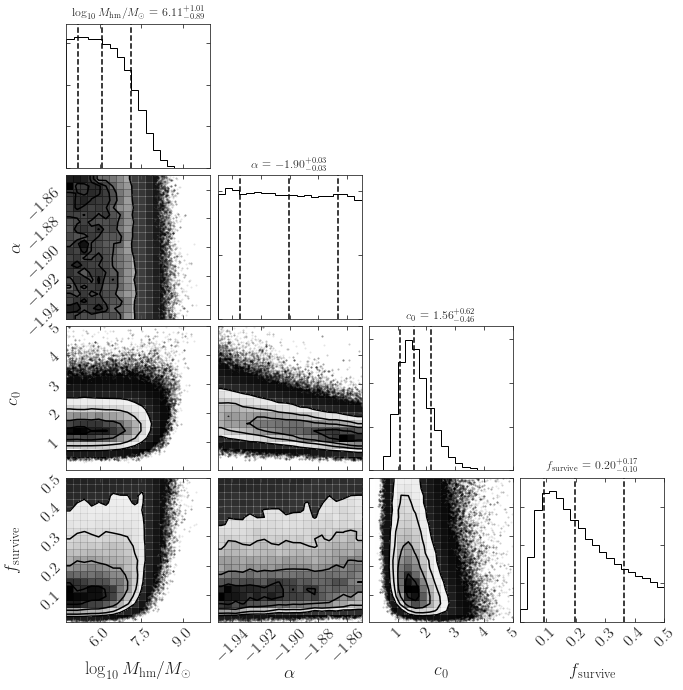

In [32]:
plot_corner_wdm(flatchain,wdm_prior=1)
if _SAVE_FIGURES:
    pyplot.savefig('full_pdf.pdf')

or with a prior that is flat in one over mass:

In [33]:
opt= fit_wdm(wdm_prior=0)
flatchain= sample_wdm(wdm_prior=0,nsam=_NSAMPLES)
print_mwdm_summary(flatchain,wdm_prior=0)

Mean acceptance fraction: 0.481
The 68% lower limit on the warm dark matter mass is 9.27 keV
The 95% lower limit on the warm dark matter mass is 4.88 keV
The 99.7% lower limit on the warm dark matter mass is 3.09 keV


### Using gamma= 1.5, beta= 0.7 in the WDM SHMF

To look at the effect of a less suppressed WDM SHMF in the inner Milky Way (Lovell et al. 2021), we run the latter analysis also with $\beta = 0.7$ and $\gamma = 1.5$, which approximates the result from Lovell et al. (2021):

In [34]:
opt= fit_wdm(wdm_prior=1,beta=0.7,gamma=1.5)
flatchain= sample_wdm(wdm_prior=1,nsam=_NSAMPLES,beta=0.7,gamma=1.5)
print_mwdm_summary(flatchain,wdm_prior=1)

Mean acceptance fraction: 0.480
The 68% lower limit on the warm dark matter mass is 9.48 keV
The 95% lower limit on the warm dark matter mass is 3.75 keV
The 99.7% lower limit on the warm dark matter mass is 1.77 keV


or with a prior that is flat in one over mass:

In [35]:
opt= fit_wdm(wdm_prior=0,beta=0.7,gamma=1.5)
flatchain= sample_wdm(wdm_prior=0,nsam=_NSAMPLES,beta=0.7,gamma=1.5)
print_mwdm_summary(flatchain,wdm_prior=0)

Mean acceptance fraction: 0.464
The 68% lower limit on the warm dark matter mass is 5.32 keV
The 95% lower limit on the warm dark matter mass is 2.06 keV
The 99.7% lower limit on the warm dark matter mass is 0.38 keV


## Constraints on fuzzy dark matter

To constrain fuzzy dark matter, we fit a model that varies the fuzzy dark matter mass, the amplitude of the SHMF, its logarithmic slope, and the fraction of subhalos that survives tidal disruption in the inner Milky Way. The following function implements the likelihood. For the classical satellites, we use Poisson statistics, while for the lower-mass bins we use the distributions above. We implement three possible priors on the fuzzy dark matter mass: (0) flat in 1/mass and (1) flat in log mass.

In [36]:
mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
def lnprob_fdm(p,fdm_prior=0,just_streams=False,
               minalpha=-1.95,maxalpha=-1.85,minc0=1e-2,maxc0=1e2):
    if fdm_prior == 0: # flat in 1/m22
        mfdm= 1./p[0]
    elif fdm_prior == 1: # flat in log10(m22)
        mfdm= 10.**p[0]
        if mfdm < 1. or mfdm > 1000: return -10000000000000.
    alpha= p[1]
    c0= numpy.exp(p[2])
    red_fac= 10.**p[3]
    if red_fac < 0.001 or red_fac > 0.5: return -10000000000000.
    if mfdm < 0.: return -10000000000000.
    if alpha < minalpha or alpha > maxalpha: return -10000000000000.
    if c0 < minc0 or c0 > maxc0: return -10000000000000.
    if not just_streams:
        # Compute number of classical satellites predicted
        nclassical= numpy.array([integrate.quad(\
                    lambda m: mass_function_fdm(m,c0=c0*2.02*1e-13,
                                                alpha=alpha,mfdm=mfdm,
                                                internal_red_fac=red_fac),
                            mass_bins[ii]/numpy.sqrt(10.**0.5),numpy.sqrt(10.**0.5)*mass_bins[ii])[0]\
                                     *mwvol for ii in range(len(mass_bins))])
        # ln like is Poisson
        out= numpy.sum([poisson.logpmf(num_sats[ii],nclassical[ii]) for ii in range(len(mass_bins)-1)])
    else:
        out= 0.
    # Compute number of low-mass subhalos that we probe with streams and convert to rate
    nlowmass= numpy.array([integrate.quad(\
                    lambda m: mass_function_fdm(m,c0=c0*2.02*1e-13,
                                                alpha=alpha,mfdm=mfdm,
                                                internal_red_fac=red_fac),
                            low_mass_bins[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*low_mass_bins[ii])[0]\
                                 *mwvol for ii in range(len(low_mass_bins))])/num_subs_cdm/scale_to_300kpc
    out+= skew_lnpdf_1e7to8(numpy.log10(nlowmass[1]))+skew_lnpdf_1e8to9(numpy.log10(nlowmass[2]))
    return out
def lnlike_fdm(p,fdm_prior=0,just_streams=False):
    return -lnprob_fdm(p,fdm_prior=fdm_prior,just_streams=just_streams)

We also implement some convenience functions to fit, MCMC sample, plot, and summarize the results:

In [37]:
def fit_fdm(fdm_prior=0,just_streams=False):
    if fdm_prior == 0:
        init= [1./5,-1.9,0.,numpy.log10(0.2)]
    elif fdm_prior == 1:
        init= [numpy.log10(5.),-1.9,0.,numpy.log10(0.2)]
    return optimize.minimize(lambda x: lnlike_fdm(x,fdm_prior=fdm_prior,just_streams=just_streams),
                             init,method='Powell')
def sample_fdm(fdm_prior=0,just_streams=False,nwalkers=26,nburn=100,nsam=1000):
    # Setup initial ball
    if fdm_prior == 0:
        init= [1./5.,-1.9,0.,numpy.log10(0.2)]
    elif fdm_prior == 1:
        init= [numpy.log10(5),-1.9,0.,numpy.log10(0.2)]
    ndim= len(init)
    # initial Gaussian ball
    p0= numpy.array(init)\
        +numpy.random.rand(ndim*nwalkers).reshape((nwalkers,len(init)))
    # Iterate until have points with non zero likelihood (within the prior rage)
    while True:
        lp= numpy.array([lnprob_fdm(p,fdm_prior=fdm_prior,just_streams=just_streams) for p in p0])
        if numpy.all(lp > -10000000000000.0): break
        indx= lp <= -10000000000000.0
        p0[indx]= numpy.array(init)\
            +numpy.random.rand(ndim*numpy.sum(indx)).reshape((numpy.sum(indx),ndim))
    # Setup sampler
    sampler= emcee.EnsembleSampler(nwalkers,ndim,lambda x: lnprob_fdm(x,fdm_prior=fdm_prior,
                                                                      just_streams=just_streams))
    pos, prob, state = sampler.run_mcmc(p0,nburn)
    sampler.reset()
    sampler.run_mcmc(pos,nsam)
    print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    return sampler.flatchain
def plot_corner_fdm(flatchain,fdm_prior=0,minalpha=-1.95,maxalpha=-1.85):
    plotthis= numpy.empty_like(flatchain)
    plotthis[:,0]= flatchain[:,0]
    plotthis[:,1]= flatchain[:,1]
    if fdm_prior == 0:
        mfdm_range= [0.,1.]
        fdm_label= r"$1/[m_{\mathrm{FDM}}/(10^{-22}\,\mathrm{eV})]$"
    elif fdm_prior == 1:
        mfdm_range= [numpy.log10(1.),numpy.log10(1000.)]
        fdm_label= r"$\log_{10} m_{\mathrm{FDM}} / (10^{-22}\,\mathrm{eV})$"
    plotthis[:,2]= numpy.exp(flatchain[:,2])
    plotthis[:,3]= 10.**flatchain[:,3]
    fig= corner.corner(plotthis,labels=[fdm_label,r"$\alpha$",r"$c_0$",r"$f_\mathrm{survive}$"],
                       range=[mfdm_range,[minalpha,maxalpha],[0.,5.],[0.01,0.5]],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
def plot_mfdm(flatchain,fdm_prior=0,cumul=False,color='k',overplot=False,ylabelpos=0.5):
    if fdm_prior == 0:
        plotthis= 1./flatchain[:,0]
    elif fdm_prior == 1:
        plotthis= 10.**flatchain[:,0]
    plotthis= numpy.log10(plotthis)
    if cumul:
        plot(sorted(plotthis),numpy.linspace(0.,1.,len(plotthis)),color=color,lw=2.)
        if not overplot: ylabel(r'$\mathrm{Cumulative\ PDF}$')
    else:
        hist(plotthis,range=[0.,3.1],bins=51,histtype='step',lw=2.,color=color,density=True)
        if not overplot: ylabel(r'$\mathrm{PDF}$')        
    if not overplot: xlabel(r"$\log_{10}( m_{{22}} = m_{\mathrm{FDM}}/ 10^{-22}\,\mathrm{eV})$")
    axvline(numpy.quantile(plotthis,0.05),color=color,ls='--')
    galpy_plot.text(0.1,ylabelpos,r'$m_{{22}} > {:.1f}$'
                    .format(numpy.quantile(10.**plotthis,0.05)),
                    fontsize=18.,color=color,backgroundcolor='w',zorder=100)
def print_mfdm_summary(flatchain,fdm_prior=0):
    if fdm_prior == 0:
        print("The 68% lower limit on the fuzzy dark matter mass is {:.2f} 1em22 eV"\
          .format(numpy.quantile(1./flatchain[:,0],0.32)))
        print("The 95% lower limit on the fuzzy dark matter mass is {:.2f} 1em22 eV"\
          .format(numpy.quantile(1./flatchain[:,0],0.05)))
        print("The 99.7% lower limit on the fuzzy dark matter mass is {:.2f} 1em22 eV"\
          .format(numpy.quantile(1./flatchain[:,0],0.003)))
    elif fdm_prior == 1:
        print("The 68% lower limit on the fuzzy, dark matter mass is {:.2f} 1em22 eV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.32)))
        print("The 95% lower limit on the fuzzy, dark matter mass is {:.2f} 1em22 eV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.05)))
        print("The 99.7% lower limit on the fuzzy dark matter mass is {:.2f} 1em22 eV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.003)))

### Constraints from streams alone

First, we look at the constraints from streams alone. Running with a prior that is flat in log-mass, we get:

In [38]:
opt= fit_fdm(fdm_prior=1,just_streams=True)
flatchain= sample_fdm(fdm_prior=1,just_streams=True,nsam=_NSAMPLES)
# Save for later use
flatchain_juststreams_fdm= flatchain.copy()
print_mfdm_summary(flatchain,fdm_prior=1)

Mean acceptance fraction: 0.437
The 68% lower limit on the fuzzy, dark matter mass is 65.38 1em22 eV
The 95% lower limit on the fuzzy, dark matter mass is 14.07 1em22 eV
The 99.7% lower limit on the fuzzy dark matter mass is 5.16 1em22 eV


or with a prior that is flat in one over mass:

In [39]:
opt= fit_fdm(fdm_prior=0,just_streams=True)
flatchain= sample_fdm(fdm_prior=0,just_streams=True,nsam=_NSAMPLES)
print_mfdm_summary(flatchain,fdm_prior=0)

Mean acceptance fraction: 0.426
The 68% lower limit on the fuzzy dark matter mass is 14.60 1em22 eV
The 95% lower limit on the fuzzy dark matter mass is 5.44 1em22 eV
The 99.7% lower limit on the fuzzy dark matter mass is 2.89 1em22 eV


### Constraints including the classical satellite counts

Next, we add the constraints coming from the classical satellite counts. Starting again with the prior that is flat in log-mass:

In [40]:
opt= fit_fdm(fdm_prior=1)
flatchain= sample_fdm(fdm_prior=1,nsam=_NSAMPLES)
print_mfdm_summary(flatchain,fdm_prior=1)

Mean acceptance fraction: 0.481
The 68% lower limit on the fuzzy, dark matter mass is 84.56 1em22 eV
The 95% lower limit on the fuzzy, dark matter mass is 22.26 1em22 eV
The 99.7% lower limit on the fuzzy dark matter mass is 10.38 1em22 eV


We compare the PDF on the fuzzy dark matter mass to that obtained from streams alone:

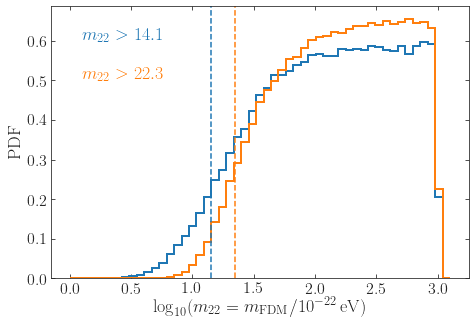

In [41]:
figsize(7.5,5)
plot_mfdm(flatchain_juststreams_fdm,fdm_prior=1,color=u'#1f77b4',ylabelpos=0.6)
plot_mfdm(flatchain,fdm_prior=1,overplot=True,color=u'#ff7f0e',ylabelpos=0.5) # u'#2ca02c'
if _SAVE_FIGURES:
    pyplot.savefig('mfdm_pdf.pdf')

We also plot the corner plot of the MCMC samples:

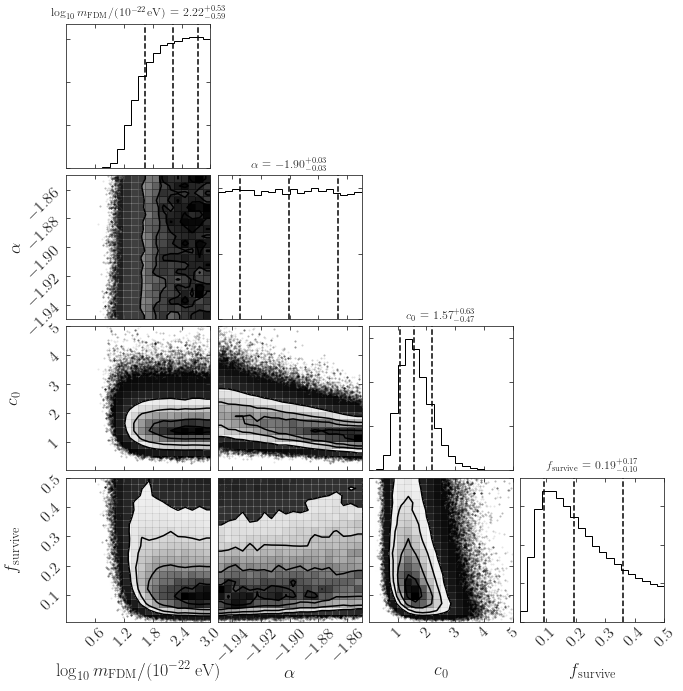

In [42]:
plot_corner_fdm(flatchain,fdm_prior=1)
if _SAVE_FIGURES:
    pyplot.savefig('full_pdf_fdm.pdf')

or with a prior that is flat in one over mass:

In [43]:
opt= fit_fdm(fdm_prior=0)
flatchain= sample_fdm(fdm_prior=0,nsam=_NSAMPLES)
print_mfdm_summary(flatchain,fdm_prior=0)

Mean acceptance fraction: 0.473
The 68% lower limit on the fuzzy dark matter mass is 26.27 1em22 eV
The 95% lower limit on the fuzzy dark matter mass is 12.12 1em22 eV
The 99.7% lower limit on the fuzzy dark matter mass is 7.30 1em22 eV


## Summary figure with more DM models

We also make a figure that includes constraints from strong lensing (translated to a rate relative to the fiducial CDM and then plotted as if it's a measurement of the MW SHMF) and include some more models. The lensing constraints were already implemented in the code that plots the data. We include another model (the large $\Theta_0$ axio) that predicts more subhalos than CDM:

In [44]:
axion_data= numpy.genfromtxt('ratio_axiontoCDM_massfunc.csv').T
def mass_function_specialaxion(m,c0=2.02*1e-13,m0=2.52*1e7,alpha=-1.9,
                               smooth_reduction=False,internal_red_fac=red_fac):
    if smooth_reduction:
        reduction= (internal_red_fac+(1.-internal_red_fac)*2./numpy.pi*numpy.arctan(m/10**9.25))
    else:
        reduction= numpy.ones_like(m)
        reduction[m<10**9.2]= internal_red_fac
    return c0*(m/m0)**alpha*reduction\
        *numpy.interp(m,axion_data[0]/0.7,axion_data[1])
def plot_specialaxion_massfunction(pred_amp_fac=1.6,red_fac=red_fac):
    pred_ms= 10.**numpy.linspace(6.,11.5,11)
    mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
    prediction_specialaxion= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_specialaxion(m,
                                                                                        internal_red_fac=red_fac),
                                    pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                              *mwvol for ii in range(len(pred_ms))])
    line_pred_specialaxion= loglog(pred_ms,prediction_specialaxion,lw=2.,
                          zorder=0,
                          color=sns.color_palette("husl",8)[7])
    galpy_plot.text(6e4,6.15e4,r'$\mathrm{Large}\ \Theta_0\ \mathrm{axion}$',
                    size=17.,color=sns.color_palette("husl",8)[7])

and we also add an SIDM model that acts much like WDM:

In [45]:
def mass_function_sidm(m,c0=2.02*1e-13,m0=2.52*1e7,alpha=-1.9,
                       mcut=1e8,
                       smooth_reduction=False,internal_red_fac=red_fac):
    if smooth_reduction:
        reduction= (internal_red_fac+(1.-internal_red_fac)*2./numpy.pi*numpy.arctan(m/10**9.25))
    else:
        reduction= numpy.ones_like(m)
        reduction[m<10**9.2]= internal_red_fac
    return c0*(m/m0)**alpha*reduction\
        *(1.+mcut/m)**(-1.34)
def plot_sidm_massfunction(pred_amp_fac=1.6,red_fac=red_fac):
    pred_ms= 10.**numpy.linspace(6.,11.5,201)
    mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
    prediction_sidm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_sidm(m,
                                                                                        internal_red_fac=red_fac),
                                    pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                              *mwvol for ii in range(len(pred_ms))])
    line_pred_sidm= loglog(pred_ms,prediction_sidm,lw=2.,
                          zorder=0,
                          color=sns.color_palette("husl",8)[1])
    galpy_plot.text(3.5e4,3.15e1,r'$\mathrm{Atomic\ SIDM}$',
                    size=17.,color=sns.color_palette("husl",8)[1])

and then we make a nice summary figure:

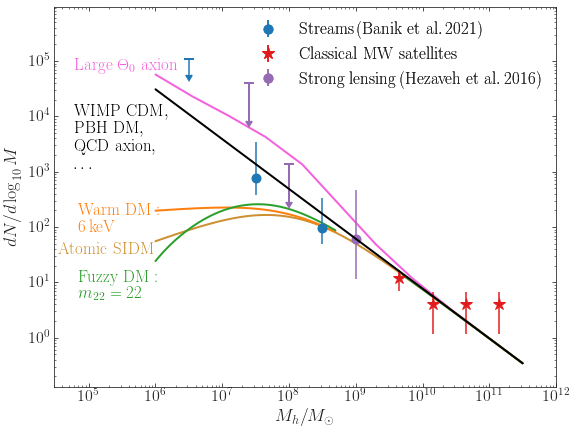

In [46]:
figsize(9,7)
plot_observed_massfunction(add_wdmmodels=True,include_lensing=True,correct_streams=1./red_fac)
plot_cdm_massfunction(noband=True)
plot_wdm_massfunction(add_single_wdm=6.,red_fac=1.)
plot_fdm_massfunction(add_single_fdm=22.,red_fac=1.)
plot_specialaxion_massfunction(red_fac=1.)
plot_sidm_massfunction(red_fac=1.)
galpy_plot.text(6e4,1.15e3,r'$\mathrm{WIMP\ CDM},$'+'\n'+r'$\mathrm{PBH\ DM},$'
                    +'\n'+r'$\mathrm{QCD\ axion},$'+'\n'+r'$\ldots$',
                    size=17.,color='k');
if _SAVE_FIGURES:
    pyplot.savefig('subhalo_massfunction_waltdm.pdf')